In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import uniform
#from BFM.MCMC_MGP import Gibbs_sampling
from BFM.MCMC_LH import Gibbs_sampling
#from BFM.MCMC_CSP import Gibbs_sampling
from BFM.VI import NGVI

In [2]:
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
P = 1000
K = 5
N = 500

In [4]:
B_0 = np.random.binomial(1,1/3,(P,K)) * np.random.rand(P,K)
sigma2_0 = np.diag(uniform.rvs(loc = 0.1, scale = 0.9, size = P))
cov_0 = B_0 @ B_0.T + sigma2_0

In [5]:
X = np.random.multivariate_normal(np.zeros(P), cov_0, N)

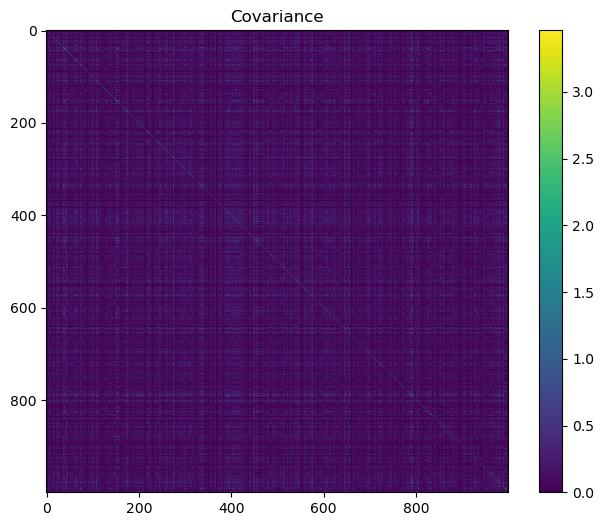

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_0)
plt.colorbar()
plt.title("Covariance")
plt.show()

In [ ]:
B_sample, sigma2_sample = Gibbs_sampling(X, device = device1, a = 1, b = 100, c = 0.3)
#B_sample, sigma2_sample = Gibbs_sampling(X, device = device1)


In [7]:
mu, Precision, np_sigma, v = NGVI(X, device = device1, a = 1, b = 100, c = 0.25)

100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


In [8]:
B = mu @ mu.T + (v / (v-2)) * torch.diag(torch.vmap(torch.trace)(torch.linalg.inv(Precision))) + torch.diag(np_sigma / (0.5 * N))

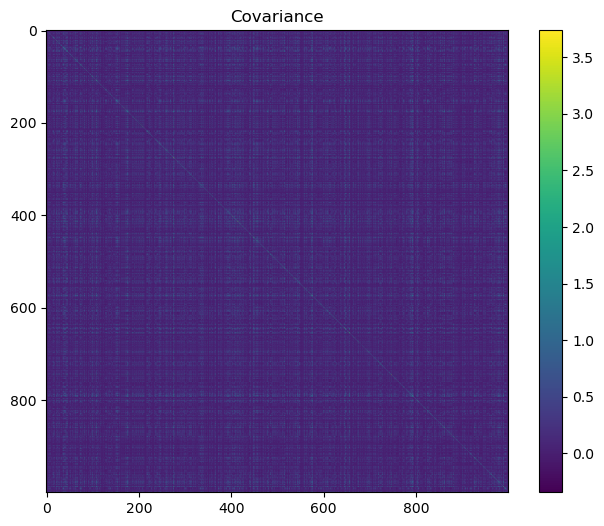

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(B.to('cpu'))
plt.colorbar()
plt.title("Covariance")
plt.show()

In [10]:
v

tensor([ 907.4367, 1129.5276,  988.0017, 1006.9136,  865.2974,  639.4585,
        1032.0138, 1191.2936,  654.2712, 1006.3371,  757.9292, 1086.4382,
        1162.7748, 1111.2735, 1047.3610, 1111.6786,  738.5373,  832.2429,
        1015.9700,  974.9602, 1044.7505, 1009.5750,  949.4717, 1112.8719,
        1043.9735, 1099.1262,  770.9827,  898.2838,  848.7942, 1011.2991,
        1025.6669, 1173.6329, 1059.0619, 1101.8146,  822.9580, 1127.5803,
         706.9891, 1225.3174,  951.4543, 1086.7809,  909.7679,  928.1435,
        1157.8948,  989.6601,  765.6849, 1017.0308,  832.1631, 1122.3235,
        1001.0524,  949.5067,  856.8675, 1025.4743,  943.9614,  946.6673,
        1029.5516, 1087.0973, 1173.3778, 1209.3661,  949.9488, 1095.0539,
         887.6331,  998.4937,  998.1147, 1142.4389,  920.4030, 1036.3275,
        1069.9470,  951.8508,  723.2942,  973.6844,  624.7590,  874.5509,
         991.2005,  956.5646, 1179.6998, 1071.3089,  824.6375,  991.4425,
         912.2538,  948.8435, 1211.265

In [11]:
(torch.from_numpy(cov_0) - B.to('cpu')).square().sum()/P**2

tensor(0.0026, dtype=torch.float64)

In [12]:
(torch.from_numpy(cov_0) - B.to('cpu')).abs().sum()/P**2

tensor(0.0329, dtype=torch.float64)

In [ ]:
for i in range(50):
    print(mu[:,i].abs().sum())

In [ ]:
A = torch.einsum('bij,bjk->bik',B_sample, B_sample.transpose(1,2))
for i in range(10000):
    A[i] = A[i] + torch.diag(sigma2_sample[i])

In [ ]:
A_mean = A.mean(0)

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(A_mean)
plt.colorbar()
plt.title("Covariance")
plt.show()

In [ ]:
(torch.from_numpy(cov_0) - A_mean).square().sum() / P**2

In [ ]:
(torch.from_numpy(cov_0) - A_mean).abs().sum() / P**2

In [ ]:
B_mean = B_sample.mean(0)

In [ ]:
for i in range(50):
    print(B_mean[:,i].abs().sum())